# Grading Forecasts for the 2016 Election

For more detail, [see here](https://github.com/BuzzFeedNews/2016-11-grading-the-election-forecasts).

In [1]:
import pandas as pd
import seaborn as sb
import sys
%matplotlib inline

## Load forecasts

In [2]:
forecasts = pd.read_csv("../data/forecasts/combined.csv")
forecasts.head()

,date,model,office,state,party,candidate,win_prob,est_diff,est_share,est_share_2p
0,2016-06-08,538_plus,P,AK,D,CLINTON,0.12260,-0.13953,0.36738,0.42021
1,2016-06-08,538_plus,P,AK,L,JOHNSON,0.00355,NaN,0.10780,NaN
2,2016-06-08,538_plus,P,AK,R,TRUMP,0.87385,0.13953,0.50691,0.57979
3,2016-06-08,538_plus,P,AL,D,CLINTON,0.01560,-0.18827,0.37487,0.39965
4,2016-06-08,538_plus,P,AL,L,JOHNSON,0.00020,NaN,0.04437,NaN


In [3]:
TRANSLATIONS = {
    "538_polls": '538 "Polls-only"',
    "538_plus": '538 "Polls-plus"',
    "dailykos": 'Daily Kos',
    "huffpost": 'Huffington Post',
    "nyt": 'NYT/Upshot',
    "pec": 'Princeton E.C.',
    "predictwise_markets": 'PredictWise Markets',
    "predictwise_overall": 'PredictWise Overall',
    "desart": "DeSart and Holbrook",
    "kremp": "Kremp/Slate",
    "pollsavvy": "PollSavvy"
}

In [4]:
def get_latest_forecasts(df):
    return df.sort_values("date")\
        .groupby(["model", "office", "state", "party", "candidate"])\
        .last()\
        .reset_index()

In [5]:
latest_forecasts = forecasts.pipe(get_latest_forecasts)

States covered, by forecast and office:

In [6]:
latest_forecasts.groupby([ "model", "office" ])["state"].nunique()\
    .unstack().fillna(0).astype(int)

office,P,S
model,,
538_plus,51,32
538_polls,51,32
dailykos,51,32
desart,51,0
huffpost,51,32
kremp,51,0
nyt,51,32
pec,51,32
pollsavvy,51,0


Those with projected Dem.-Rep. percentage diffs:

In [7]:
latest_forecasts[
    latest_forecasts["est_diff"].notnull()
].groupby([ "model", "office" ])["state"].nunique()\
    .unstack().fillna(0).astype(int)

office,P,S
model,,
538_plus,51,32
538_polls,51,32
huffpost,51,18
nyt,51,32
pec,51,14
pollsavvy,51,0


Make sure that probabilities within each race all sum to 1.0000

In [8]:
latest_forecasts.groupby([
   "date", "model", "office", "state"
])["win_prob"].sum().round(4).value_counts()

1.0    817
Name: win_prob, dtype: int64

# Set up the calculations

In [9]:
# Counting only Maine and Nebraska's statewide electoral votes
ELECTORAL_VOTES = pd.Series({
    "AL": 9, "AK": 3, "AZ": 11, "AR": 6, "CA": 55, "CO": 9, "CT": 7,
    "DE": 3, "DC": 3, "FL": 29, "GA": 16, "HI": 4, "ID": 4, "IL": 20, "IN": 11,
    "IA": 6, "KS": 6, "KY": 8, "LA": 8, "ME": 2, "MD": 10, "MA": 11, "MI": 16,
    "MN": 10, "MS": 6, "MO": 10, "MT": 3, "NE": 2, "NV": 6, "NH": 4, "NJ": 14,
    "NM": 5, "NY": 29, "NC": 15, "ND": 3, "OH": 18, "OK": 7, "OR": 7, "PA": 20,
    "RI": 4, "SC": 9, "SD": 3, "TN": 11, "TX": 38, "UT": 6, "VT": 3,
    "VA": 13, "WA": 12, "WV": 5, "WI": 10, "WY": 3
})

def get_evs(abbr):
    return ELECTORAL_VOTES.get(abbr)

In [10]:
def brier_score_race(called_forecast):
    uniques = called_forecast[[
        "date", "office", "state", "model"
    ]].apply(lambda x: x.nunique())
    assert((uniques != 1).sum() == 0)
    errors = called_forecast["win_prob"] - called_forecast["correct"]
    errors_squared = (errors).pow(2).sum()
    # If you didn't put odds on the candidate (e.g., McMullin in UT, add 1)
    if called_forecast["correct"].sum() == 0:
        errors_squared += 1
    return errors_squared / 2

In [11]:
class Scenario(object):
    def __init__(self, winners, forecasts):
        self.winners = winners
        self.forecasts = forecasts
        self.called = self.judge_called_races()
        self.credits = self.calc_credits()
        self.brier_scores = self.calc_brier_scores()
        self.log_scores = self.calc_log_scores()
        self.forecast_scores = self.calc_forecast_scores()
    
    @classmethod
    def from_csv(cls, path, forecasts):
        winners = pd.read_csv(path)
        return cls(winners, forecasts)
    
    @property
    def uncalled_races(self):
        called_races = self.winners[
            self.winners["winner"].notnull()
        ].set_index(["office", "state"]).index
        # Assume Gary Johnson has zero chance of winning any state
        unique_races = latest_forecasts[
            ~((latest_forecasts["candidate"] == "JOHNSON") &
            (latest_forecasts["office"] == "P"))
        ].groupby(["office", "state"])["candidate"].unique()
        return unique_races[
            ~unique_races.index.isin(called_races)
        ]
    
    @property
    def evs_called(self):
        return pd.Series(self.winners[
            (self.winners["office"] == "P") &
            (self.winners["winner"].notnull())
        ]["state"].unique()).apply(get_evs).sum()
    
    @property
    def pres_diffs_final(self):
        return len(self.winners[
            (self.winners["office"] == "P") &
            (self.winners["state"] != "DC") &
            (self.winners["dem_diff"].notnull())
        ])
    
    def judge_called_races(self):
        called = pd.merge(
            self.winners,
            self.forecasts,
            on=[ "office", "state" ],
            how="left"
        ).dropna(subset=["winner"])
        called["correct"] = called["winner"] == called["candidate"]
        return called
    
    def calc_credits(self):
        def get_credits(race):
            max_prob = race["win_prob"].max()
            at_max = race["win_prob"] == max_prob
            favorites = race[at_max]
            credit = (1 / len(favorites)) * favorites["correct"]
            return credit.sum()
        return pd.DataFrame({
            "credit": self.called.groupby([
                    "date", "model", "office", "state"
                ]).apply(get_credits)
        }).reset_index()
    
    def calc_brier_scores(self):
        scores = pd.merge(
            self.called,
            self.forecasts[["date", "model"]].drop_duplicates(),
            how="inner",
            on=["date", "model"]
        ).groupby([
            "date",
            "office",
            "state",
            "model",
        ]).apply(brier_score_race)\
            .reset_index()\
            .rename(columns={0: "brier_score"})
        scores.loc[(
            (scores["office"] == "P")
        ), "brier_evs"] = scores.apply(lambda x: x["brier_score"] * get_evs(x["state"]), axis=1)
        return scores

    def calc_log_scores(self):
        # NOTE: To account for the various levels of precision reported,
        # these calculations convert 0% odds to 0.01% odds (i.e., 1 in 10,000).
        scores = pd.merge(
            self.called[self.called["candidate"] == self.called["winner"]],
            self.forecasts[["date", "model", ]].drop_duplicates(),
            how="inner",
            on=["date", "model"]
        ).groupby([
            "date",
            "office",
            "state",
            "model",
            "win_prob"
        ]).apply(lambda x: pd.np.math.log(max(x["win_prob"].iloc[0], 0.0001)))\
            .reset_index()\
            .rename(columns={0: "log_score"})
        scores.loc[(
            (scores["office"] == "P")
        ), "log_evs"] = scores.apply(lambda x: x["log_score"] * get_evs(x["state"]), axis=1)
        return scores

    def calc_squared_errors_share(self):
        errors = pd.merge(
            self.called[
                (self.called["office"] == "P") &
                (self.called["party"] == "D") &
                ~(self.called["state"].isin([ "DC", "UT" ]))
            ],
            self.forecasts[["date", "model"]].drop_duplicates(),
            how="inner",
            on=["date", "model"]
        ).groupby([
            "date",
            "office",
            "state",
            "model",
            "est_share_2p"
        ]).apply(lambda x: pow(x.iloc[0]["est_share_2p"] - x.iloc[0]["dem_share_2p"], 2))\
            .reset_index()\
            .rename(columns={0: "squared_error"})
        return errors
    
    def calc_squared_errors_diff(self):
        errors = pd.merge(
            self.called[
                (self.called["office"] == "P") &
                (self.called["party"] == "D") &
                ~(self.called["state"].isin([ "DC", "UT" ]))
            ],
            self.forecasts[["date", "model"]].drop_duplicates(),
            how="inner",
            on=["date", "model"]
        ).groupby([
            "date",
            "office",
            "state",
            "model",
            "est_diff"
        ]).apply(lambda x: pow(x.iloc[0]["est_diff"] - x.iloc[0]["dem_diff"], 2))\
            .reset_index()\
            .rename(columns={0: "squared_error"})
        return errors

    def biggest_misses(self, val):
        return {
            "brier_score": self.brier_scores,
            "brier_evs": self.brier_scores,
            "log_score": self.log_scores,
            "log_evs": self.log_scores,
        }[val].sort_values(val, ascending=False if "brier" in val else True)\
            .reset_index(drop=True)[[ "date", "model", "office", "state", val]]
    
    def calc_forecast_scores(self):
        pb = self.brier_scores[self.brier_scores["office"] == "P"]
        sb = self.brier_scores[self.brier_scores["office"] == "S"]
        pl = self.log_scores[self.log_scores["office"] == "P"]
        sl = self.log_scores[self.log_scores["office"] == "S"]
        
        scores = pd.DataFrame({
            "pres_brier_flat": pb.groupby("model")["brier_score"].mean(),
            "pres_brier_evs": pb.groupby("model")["brier_evs"].sum() / self.evs_called,
            "sen_brier_flat": sb.groupby("model")["brier_score"].mean(),
            "pres_log_flat": pl.groupby("model")["log_score"].mean(),
            "pres_log_evs": pl.groupby("model")["log_evs"].sum() / self.evs_called,
            "sen_log_flat": sl.groupby("model")["log_score"].mean(),
            "pres_correct": self.credits[self.credits["office"] == "P"].groupby("model")["credit"].sum(),
            "sen_correct": self.credits[self.credits["office"] == "S"].groupby("model")["credit"].sum()
        })
        return scores

## Load called races

Note: State vote counts/shares come from the [Cook Political Report's 2016 National Popular Vote Tracker](https://docs.google.com/spreadsheets/d/133Eb4qQmOxNvtesw2hdVns073R68EZx4SfCnP4IGQf8/htmlview?sle=true#gid=19).

In [12]:
WINNERS_PATH = "../data/reference/winners.csv"

In [13]:
current_scenario = Scenario.from_csv(WINNERS_PATH, latest_forecasts)

Electoral votes called so far (ignoring district-allocated EVs in Maine and Nebraska):

In [14]:
current_scenario.evs_called

533

## Brier and log-likelihood scores

### Statewide presidential races (incl. D.C.)

In [15]:
current_scenario.forecast_scores.round(4)\
    .sort_values("pres_brier_evs").fillna("")\
    [[ "pres_brier_evs", "pres_brier_flat",
       "pres_log_evs", "pres_log_flat", "pres_correct" ]].rename(index=TRANSLATIONS)#.to_csv(sys.stdout)

,pres_brier_evs,pres_brier_flat,pres_log_evs,pres_log_flat,pres_correct
"538 ""Polls-plus""",0.0928,0.0664,-0.2724,-0.2123,46.0
"538 ""Polls-only""",0.0936,0.0672,-0.2749,-0.2160,46.0
Princeton E.C.,0.1169,0.0744,-0.3602,-0.2471,47.0
NYT/Upshot,0.1208,0.0801,-0.3601,-0.2554,46.0
Kremp/Slate,0.1210,0.0766,-0.3873,-0.2595,46.0
PollSavvy,0.1219,0.0794,-0.3613,-0.2488,46.0
PredictWise Markets,0.1272,0.0767,-0.3929,-0.2523,46.0
PredictWise Overall,0.1276,0.0783,-0.4083,-0.2705,46.0
DeSart and Holbrook,0.1279,0.0825,-0.4053,-0.2708,44.0
Daily Kos,0.1439,0.0864,-0.8772,-0.5629,46.0


### Senate races

By Brier score:

In [16]:
current_scenario.forecast_scores.round(4)\
    .sort_values("sen_brier_flat").dropna().fillna("")\
    [[ "sen_brier_flat", "sen_log_flat", "sen_correct", ]].rename(index=TRANSLATIONS)#.to_csv(sys.stdout)

,sen_brier_flat,sen_log_flat,sen_correct
"538 ""Polls-plus""",0.0565,-0.1704,30.0
NYT/Upshot,0.0569,-0.1667,30.0
"538 ""Polls-only""",0.0587,-0.1758,29.0
PredictWise Markets,0.0596,-0.1777,30.0
PredictWise Overall,0.0606,-0.1852,30.0
Daily Kos,0.0610,-0.1735,29.0
Princeton E.C.,0.0637,-0.1771,28.5
Huffington Post,0.0956,-0.3579,29.0


By log score:

In [17]:
current_scenario.forecast_scores.round(4)\
    .sort_values("sen_log_flat", ascending=False).dropna().fillna("")\
    [[ "sen_brier_flat", "sen_log_flat", "sen_correct", ]].rename(index=TRANSLATIONS)#.to_csv(sys.stdout)

,sen_brier_flat,sen_log_flat,sen_correct
NYT/Upshot,0.0569,-0.1667,30.0
"538 ""Polls-plus""",0.0565,-0.1704,30.0
Daily Kos,0.0610,-0.1735,29.0
"538 ""Polls-only""",0.0587,-0.1758,29.0
Princeton E.C.,0.0637,-0.1771,28.5
PredictWise Markets,0.0596,-0.1777,30.0
PredictWise Overall,0.0606,-0.1852,30.0
Huffington Post,0.0956,-0.3579,29.0


## Biggest misses (flat Brier score)

In [18]:
current_scenario.biggest_misses("brier_score").head(15).fillna("")

,date,model,office,state,brier_score
0,2016-11-07,dailykos,P,MI,1.000000
1,2016-11-07,dailykos,P,PA,0.999400
2,2016-11-07,dailykos,P,WI,0.998800
3,2016-11-07,huffpost,P,PA,0.994129
4,2016-11-07,huffpost,P,WI,0.982874
5,2016-11-07,huffpost,P,MI,0.977745
6,2016-11-07,huffpost,S,WI,0.966348
7,2016-11-07,predictwise_overall,P,WI,0.960400
8,2016-11-07,kremp,P,WI,0.960400
9,2016-11-07,pec,P,WI,0.960400


## Biggest misses  as Brier * Electoral College votes

In [19]:
current_scenario.biggest_misses("brier_evs").head(15).fillna("")

,date,model,office,state,brier_evs
0,2016-11-07,huffpost,P,FL,22.953869
1,2016-11-07,dailykos,P,FL,21.508298
2,2016-11-07,dailykos,P,PA,19.988002
3,2016-11-07,huffpost,P,PA,19.882573
4,2016-11-07,predictwise_markets,P,FL,18.560000
5,2016-11-07,predictwise_markets,P,PA,17.672000
6,2016-11-07,kremp,P,PA,17.672000
7,2016-11-07,predictwise_overall,P,PA,17.672000
8,2016-11-07,predictwise_overall,P,FL,17.194100
9,2016-11-07,desart,P,PA,17.149520


## EV-weighted Brier history

Charting the eventual accuracy of each forecast every day since Sept. 2016, for forecasts that have published or made available their forecast histories:

In [20]:
%%time
history = forecasts[forecasts["date"] >= "2016-09-01"].groupby("date")\
    .apply(lambda x: Scenario.from_csv(WINNERS_PATH, x).forecast_scores)

CPU times: user 2min 18s, sys: 1.96 s, total: 2min 20s
Wall time: 2min 27s


In [21]:
COLORS = [ 
    "#a6cee3", "#1f78b4", "#b2df8a", "#33a02c", "#fb9a99", "#e31a1c", 
    "#fdbf6f", "#ff7f00", "#cab2d6", "#6a3d9a", "#ffff99", "#b15928"
] # via ColorBrewer2.org

In [22]:
def plot_history(var, title=""):
    chart_min = history[var].max()*1.1
    chart_max = history[var].min()/1.1
    vals = history[var].unstack().rename(columns=TRANSLATIONS)
    vals.index = pd.to_datetime(vals.index)
    ax = vals.plot(
        ylim=(chart_min, chart_max),
        color=COLORS,
        marker="o",
        markersize=5,
        alpha=0.75,
        figsize=(10, 6),
    )
    ax.set_axis_bgcolor('black')
    ax.xaxis.grid(False)
    ax.yaxis.grid(True, color="white", alpha=0.5)
    sb.plt.vlines(["2016-11-07"], ymin=chart_min, ymax=chart_max, lw=1, alpha=0.9, color="white")
    ax.set_xlim((ax.get_xlim()[0] - 1, ax.get_xlim()[1] + 1))
    ax.set_xlabel("")
    for text in ax.legend(loc="lower left").get_texts():
        text.set_color("white")
        text.set_weight("bold")
    ax.set_title(title, fontsize=18)


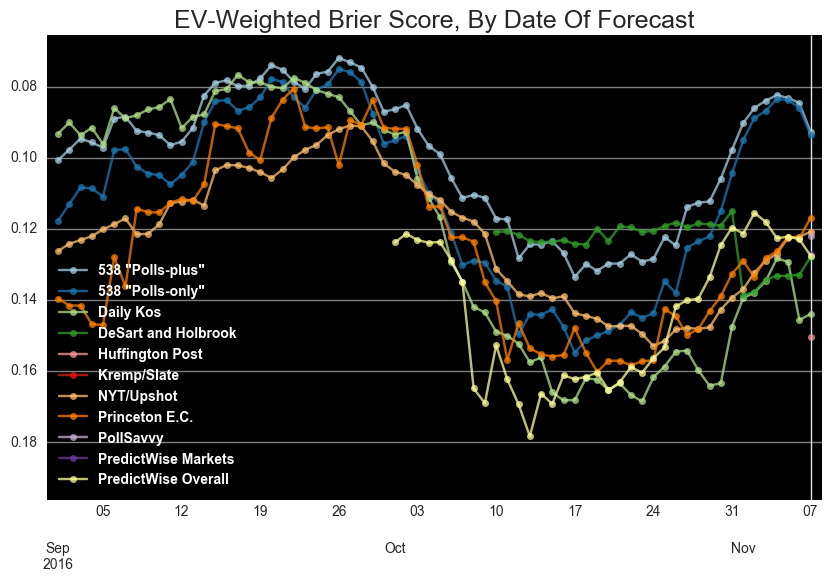

In [23]:
plot_history("pres_brier_evs", "EV-Weighted Brier Score, By Date Of Forecast")

# How closely did they forecast the Dem.-Rep. difference?

In [24]:
current_scenario.calc_squared_errors_diff()\
    .groupby([ "model" ])["squared_error"].sum().pow(0.5).sort_values()\
    .rename(index=TRANSLATIONS)#.to_csv(sys.stdout)

model
538 "Polls-plus"    0.473363
538 "Polls-only"    0.479719
Princeton E.C.      0.493595
NYT/Upshot          0.495042
Huffington Post     0.507362
PollSavvy           0.555307
Name: squared_error, dtype: float64

In [25]:
current_scenario.calc_squared_errors_share()\
    .groupby([ "model" ])["squared_error"].sum().pow(0.5).sort_values()\
    .rename(index=TRANSLATIONS)#.to_csv(sys.stdout)

model
Daily Kos              0.219680
Kremp/Slate            0.222946
DeSart and Holbrook    0.246911
538 "Polls-plus"       0.250996
538 "Polls-only"       0.254569
PollSavvy              0.277613
Name: squared_error, dtype: float64

# Chart the forecasts' "calibration"

The charts below group, for each forecaster, each Presidential prediction they made into six categories, in terms of Trump's perceived chance of winning:

- 0% up to 10%
- 10% up to 30%
- 30% up to 50%
- 50% up to 70%
- 70% up to 90%
- 90% through 100%

For each category, the chart plots the percentage of those states that Trump won.

In [26]:
bands = [
    (0, 0.1), (0.1, 0.3), (0.3, 0.5), 
    (0.5, 0.7), (0.7, 0.9), (0.9, 1)
]

In [27]:
def band_classifier(x):
    for low, high in bands:
        if x >= low and x < high:
            return (low, high)
    return bands[-1]

In [28]:
grp = current_scenario.called[
    (current_scenario.called["party"] == "R") &
    (current_scenario.called["office"] == "P")
].groupby([
    "model",
    current_scenario.called["win_prob"].apply(band_classifier)
])
calibration = pd.DataFrame({
    "mean": grp["correct"].mean(),
    "n": grp.size()
}).rename(index=TRANSLATIONS).unstack(level=0)
calibration["midpoint"] = [ sum(x)/2 for x in bands ]
calibration = calibration.set_index("midpoint")

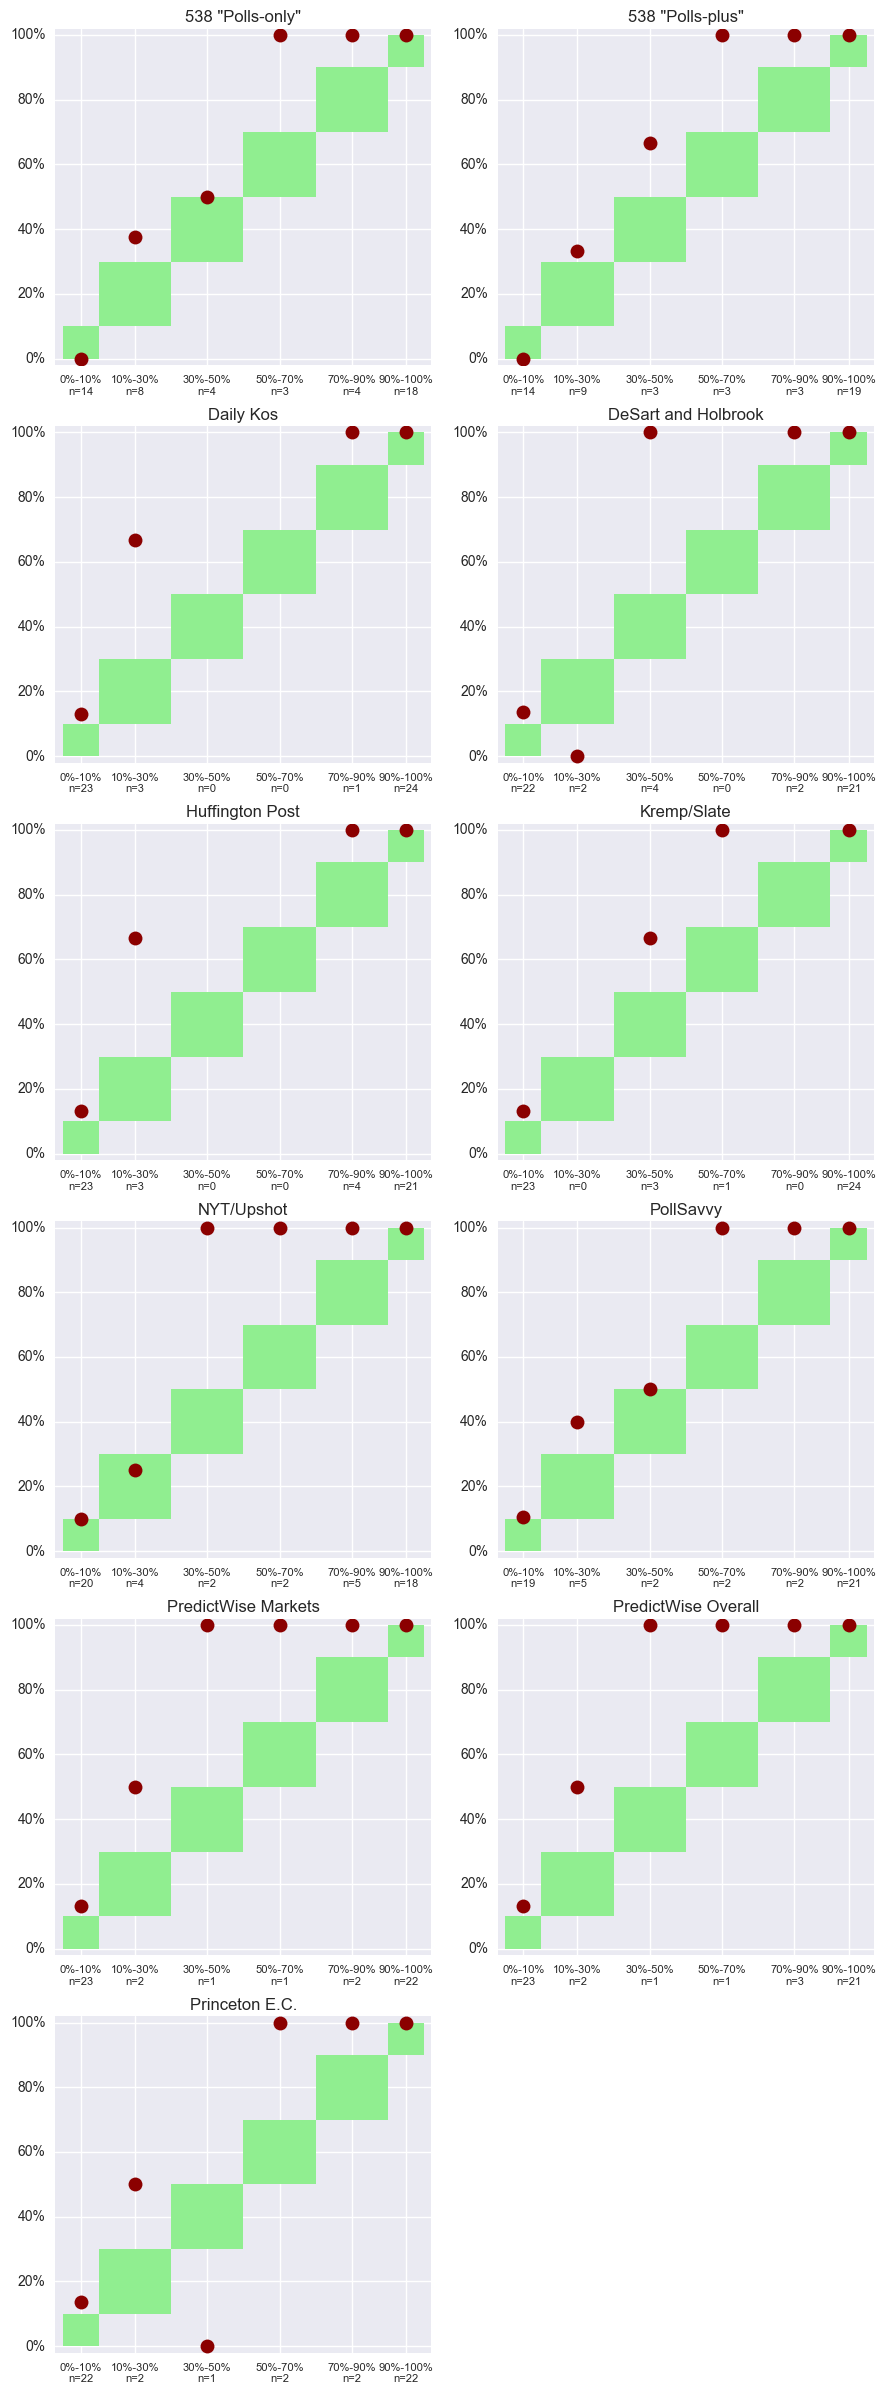

In [29]:
for i, fc in enumerate(calibration["mean"].columns):
    sb.plt.subplot(6, 2, i+1)
    ax = calibration["mean"][fc].plot(figsize=(9, 24), lw=0, marker="o", markersize=10, color="darkred")
    ax.set_xlim(-0.02, 1.02)
    ax.set_ylim(-0.02, 1.02)
    ax.set_title(fc)
    ax.set_xlabel("")
    ax.set_yticklabels([ "{0:.0f}%".format(y * 100) for y in ax.get_yticks() ])
    ax.set_xticks([ (x1 + x0)/2 for x1, x0 in bands ])
    ax.set_xticklabels([ "{0:.0f}%-{1:.0f}%\nn={2:.0f}"\
        .format(x0 * 100, x1 * 100, calibration["n"][fc].fillna(0)[(x0 + x1)/2])
            for x0, x1 in bands ], fontsize=8)
    for x0, x1 in bands:
        ax.add_patch(sb.plt.Rectangle((x0, x0), x1 - x0, x1 - x0, 
        facecolor="lightgreen", lw=0))
ax.figure.tight_layout()
pass

---

---

---